In [1]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [2]:
LEVERAGE = 10
INITIAL_CAP = 200000

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [3]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [4]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)

df = df[['Date', 'Close', 'EFFR']]

In [5]:
df

,Date,Close,EFFR
0,2014-01-02,30.055000,0.08
1,2014-01-03,30.035000,0.08
2,2014-01-06,30.160000,0.08
3,2014-01-07,30.260000,0.07
4,2014-01-08,30.150000,0.07
...,...,...,...
1504,2019-12-23,39.160000,1.55
1505,2019-12-24,39.290001,1.55
1506,2019-12-26,39.389999,1.55
1507,2019-12-27,39.419998,1.55


In [6]:
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
df['EFFR'] = df['EFFR'] / 100
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
df

,Date,Close,EFFR,Daily_EFFR
0,2014-01-02,30.055000,0.0008,3.174603e-08
1,2014-01-03,30.035000,0.0008,3.174603e-08
2,2014-01-06,30.160000,0.0008,3.174603e-08
3,2014-01-07,30.260000,0.0007,2.777778e-08
4,2014-01-08,30.150000,0.0007,2.777778e-08
...,...,...,...,...
1504,2019-12-23,39.160000,0.0155,6.150794e-07
1505,2019-12-24,39.290001,0.0155,6.150794e-07
1506,2019-12-26,39.389999,0.0155,6.150794e-07
1507,2019-12-27,39.419998,0.0155,6.150794e-07


In [7]:
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']
df['Daily_excess_leverage_return'] = df['Daily_excess_return'] * LEVERAGE
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                         0.0009
Daily_EFFR                                      0.0
Daily_return                               0.005885
Daily_excess_return                        0.005885
Daily_excess_leverage_return               0.058849
Name: 196, dtype: object

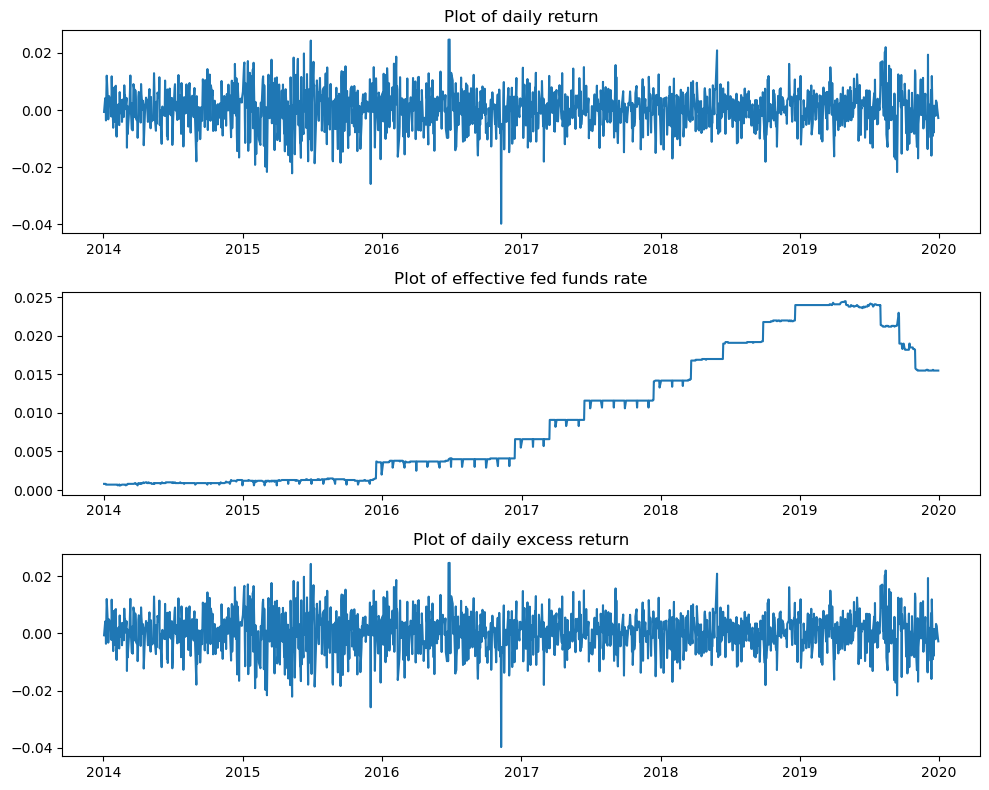

In [8]:
fig, ax = plt.subplots(3, 1, figsize = (10, 8))

ax[0].plot(df['Date'], df['Daily_return'])
ax[0].set_title('Plot of daily return')
ax[1].plot(df['Date'], df['EFFR'])
ax[1].set_title('Plot of effective fed funds rate')
ax[2].plot(df['Date'], df['Daily_excess_return'])
ax[2].set_title('Plot of daily excess return')
plt.tight_layout()

## 2. Trading Strategies

### Strategy: LSTM Strategy

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [10]:
df['ema12'] = df['Close'].ewm(span = 12).mean()
df['ema26'] = df['Close'].ewm(span = 26).mean()
df['macd'] = df['ema12'] - df['ema26']
df['macd_signal'] = df['macd'].ewm(span = 9).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']

In [11]:
df

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return,ema12,ema26,macd,macd_signal,macd_hist
0,2014-01-02,30.055000,0.0008,3.174603e-08,NaN,NaN,NaN,30.055000,30.055000,0.000000,0.000000,0.000000
1,2014-01-03,30.035000,0.0008,3.174603e-08,-0.000665,-0.000665,-0.006655,30.044167,30.044615,-0.000449,-0.000249,-0.000199
2,2014-01-06,30.160000,0.0008,3.174603e-08,0.004162,0.004162,0.041618,30.089376,30.086072,0.003304,0.001207,0.002097
3,2014-01-07,30.260000,0.0007,2.777778e-08,0.003316,0.003316,0.033156,30.143236,30.134695,0.008541,0.003692,0.004849
4,2014-01-08,30.150000,0.0007,2.777778e-08,-0.003635,-0.003635,-0.036352,30.145073,30.138244,0.006829,0.004625,0.002204
...,...,...,...,...,...,...,...,...,...,...,...,...
1504,2019-12-23,39.160000,0.0155,6.150794e-07,-0.002039,-0.002039,-0.020394,39.514002,39.703280,-0.189278,-0.106898,-0.082380
1505,2019-12-24,39.290001,0.0155,6.150794e-07,0.003320,0.003319,0.033191,39.479540,39.672667,-0.193127,-0.124144,-0.068983
1506,2019-12-26,39.389999,0.0155,6.150794e-07,0.002545,0.002545,0.025445,39.465765,39.651728,-0.185964,-0.136508,-0.049456
1507,2019-12-27,39.419998,0.0155,6.150794e-07,0.000762,0.000761,0.007610,39.458724,39.634563,-0.175840,-0.144374,-0.031465


<BarContainer object of 1509 artists>

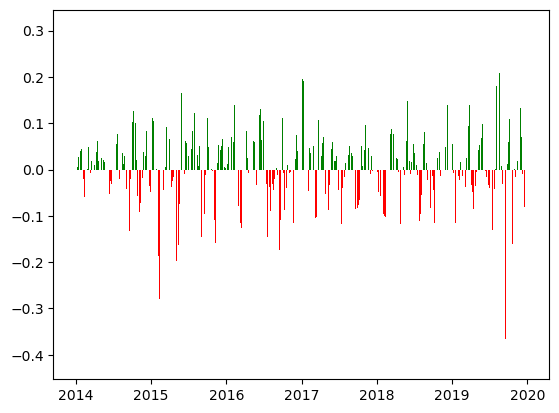

In [12]:
color = np.where(df['macd_hist'] >= 0, 'green', 'red')

# plt.plot(df['Date'], df['macd'], label = 'MACD')
# plt.plot(df['Date'], df['macd_signal'], label = 'Signal')
plt.bar(df['Date'], df['macd_hist'], color = color)

In [13]:
df = df.dropna()
regime = [0]
macd_hist = np.array(df['macd_hist'])
for i in range(1, len(macd_hist)):
    if macd_hist[i] > 0 and macd_hist[i-1] <= 0:
        regime.append(1)
    elif macd_hist[i] < 0 and macd_hist[i-1] >= 0:
        regime.append(-1)
    else:
        regime.append(0)

In [14]:
df_test = pd.read_csv('Test.csv')
df_test = df_test.rename({'Daily EFFR': "Daily_EFFR", 'Excess return': 'Daily_excess_return'}, axis = 1)
df_test

,t,Date,Close,Daily_EFFR,Daily return,Daily_excess_return,signals
0,0,1,30.055,0.000317,0.000000,0.000000,0
1,1,2,30.035,0.000317,-0.000665,-0.000983,1
2,2,3,30.160,0.000317,0.004162,0.003844,0
3,3,4,30.260,0.000278,0.003316,0.003038,-1


In [15]:
result = compute_position_value(df = df_test, 
                           signal = np.array(df_test['signals']), 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0=False)
result["Vtot"]

array([200063.492     , 198097.02392316, 198159.91180438, 192140.04156766])

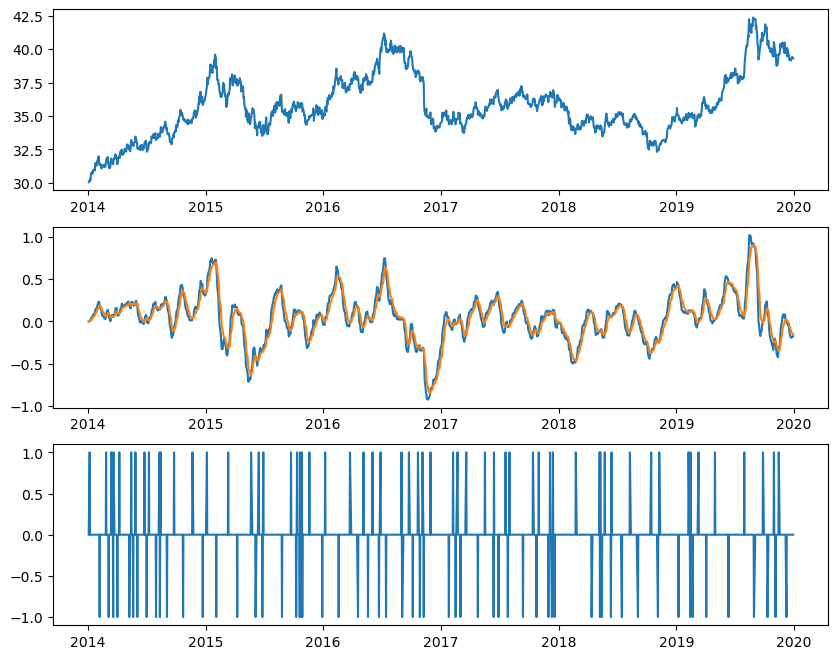

In [18]:

fig, ax = plt.subplots(3, 1, figsize = (10, 8))

ax[0].plot(df['Date'], df['Close'])
ax[1].plot(df['Date'], df['macd'])
ax[1].plot(df['Date'], df['macd_signal'])
ax[2].plot(df['Date'], np.array(regime))

In [46]:
def get_theta_and_V(
    daily_excess_return_series : np.ndarray,
    price_series,
    daily_risk_free_series : np.ndarray,
    signal : np.ndarray,
    initial_cash : float = 200_000.,
    leverage : float = 5.):
    """ 
    Evaluates a mean reversion strategy given a signal and returns the theta, V_asset, V_cap and V_total

    Arguments:
    ----------
    daily_excess_return_series  : {np.ndarray}
                                    > The daily excess return series
    daily_risk_free_series      : {np.ndarray}
                                    > The daily risk free rate series  
    signal                      : {np.ndarray}
                                    > The signal series
    initial_cash                : {float}
                                    > The initial cash
    leverage                    : {float}
                                    > The leverage

    Returns:
    ----------
    theta                       : {np.ndarray}
                                    > The dollar values (either long or short)
    V                           : {np.ndarray}
                                    > The unlevereaged value of the assets.
    V_cap                       : {np.ndarray}
                                    > The value of the unused capital. 
    V_total                     : {np.ndarray}
                                    > The total value of the holdings.
    """
    # ge let n_days
    n_days = len(signal)

    # set up
    theta = np.zeros((n_days,))

    # assets
    V_t = np.zeros((n_days,))
    delta_V_t = np.zeros((n_days,))

    # money market
    V_cap = np.zeros((n_days,))
    delta_V_cap = np.zeros((n_days,))

    # total
    V_total = np.zeros((n_days,))
    delta_V_total = np.zeros((n_days,))

    # # initial values
    V_t[0] = initial_cash
    delta_V_t[0] = 0
    V_cap[0] = 0
    delta_V_cap[0] = 0
    V_total[0] = V_t[0] + delta_V_cap[0]
    delta_V_total[0] = 0
    unit = np.zeros(n_days)

    # backtest strategy
    for i, s in enumerate(signal[:-1]):

        if i == 0:
            continue
        if s != 0:
            unit[i] = s * V_total[i-1] * leverage / price_series[i]
        else:
            unit[i] = unit[i-1]
        
        
        # get position size
        # theta[i] = V_t[i-1] * leverage * s
        theta[i] = unit[i] * price_series[i]

        # get V_t
        delta_V_t[i] = (daily_excess_return_series[i+1] * theta[i]) 
        V_t[i] = delta_V_t[i] + V_t[i-1]
        
        # get V_cap_t
        M = np.abs(theta[i]) / leverage
        delta_V_cap[i] = (V_total[i-1] - M) * (daily_risk_free_series[i+1]) 
        V_cap[i] = delta_V_cap[i] + V_cap[i-1]

        # Get V_total_t
        delta_V_total[i] = delta_V_t[i] + delta_V_cap[i]
        V_total[i] = delta_V_total[i] + V_total[i-1]

    strategy_data = {
        "theta" : theta,
        "V_t" : V_t,
        "delta_V_t" : delta_V_t,
        "V_cap" : V_cap,
        "delta_V_cap" : delta_V_cap,
        "V_total" : V_total,
        "delta_V_total" : delta_V_total}

    
    return strategy_data

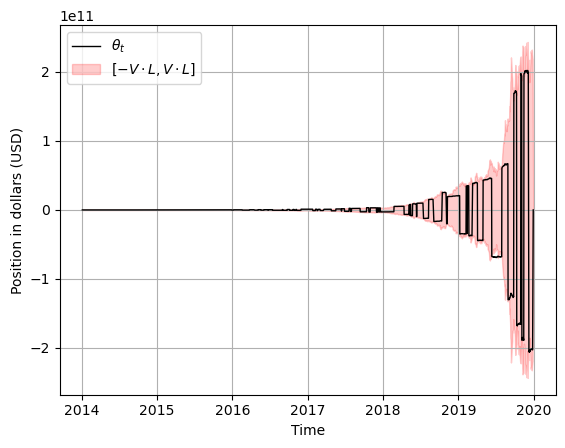

In [56]:
RES = get_theta_and_V(
    daily_excess_return_series = df['Daily_excess_return'],
    price_series = np.array(df['Close']),
    daily_risk_free_series  = df['Daily_EFFR'],
    signal = regime,
    initial_cash = 200000,
    leverage =10)

plot_position(df['Date'], RES['theta'], RES['V_total'], leverage=LEVERAGE) 

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


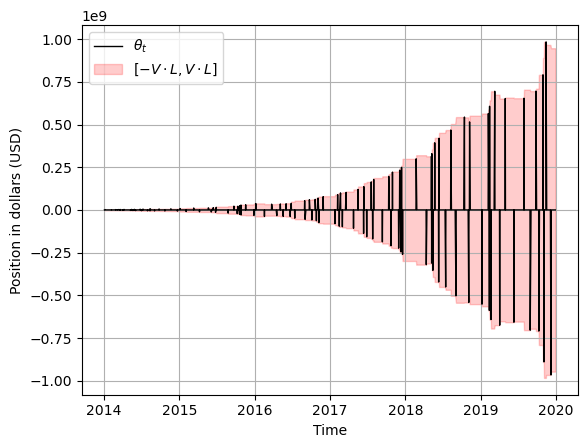

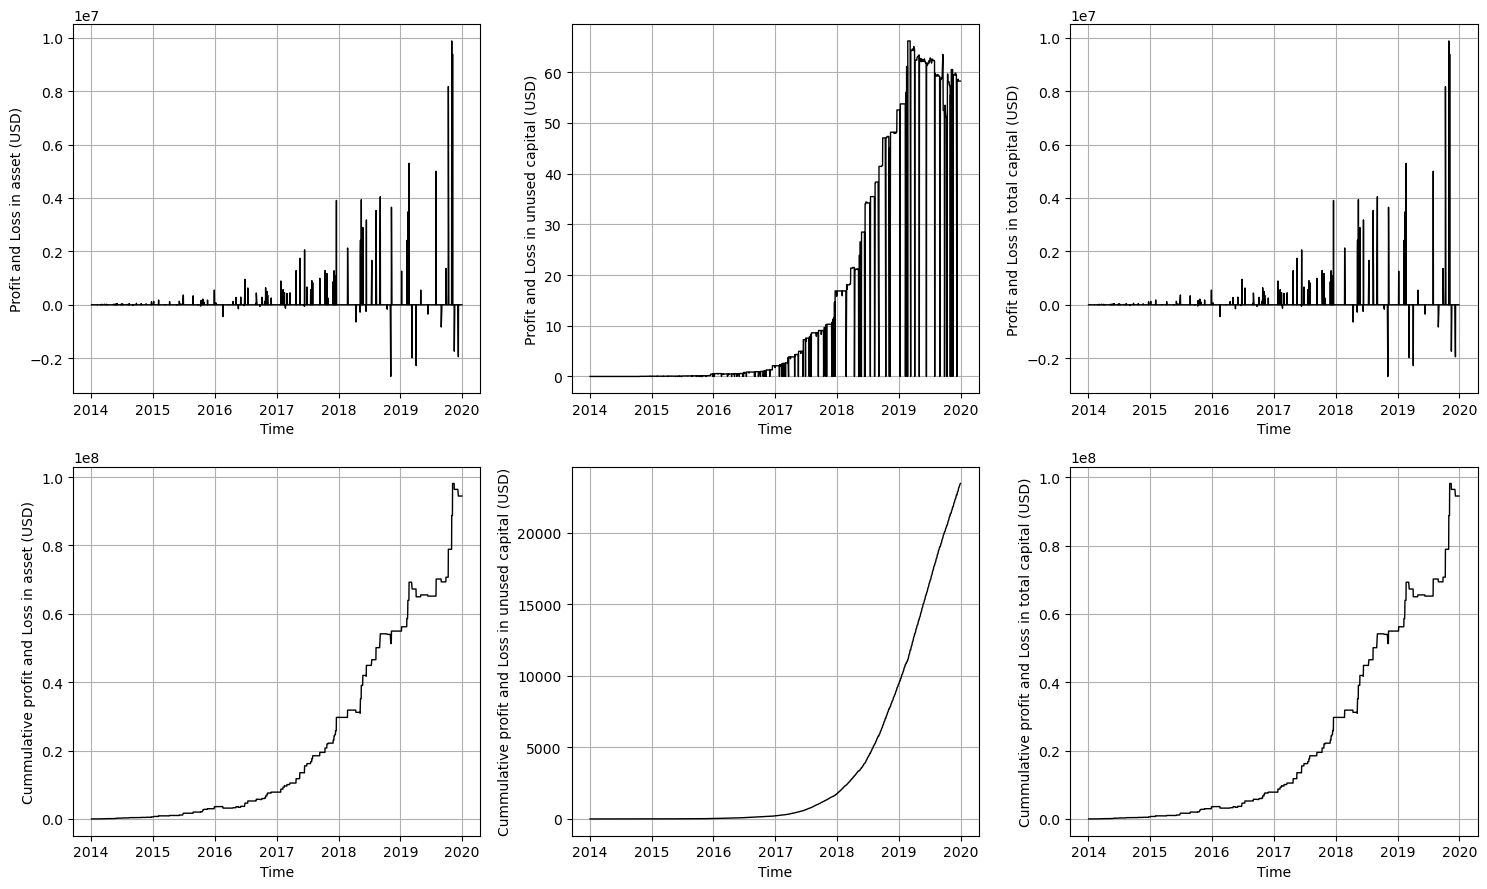

In [58]:

result = compute_position_value(df = df, 
                           signal = np.array(regime), 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0= False)
plot_position(df['Date'], result['theta'], result['Vtot'], leverage=LEVERAGE) 

plot_PnL(df['Date'], result['dV'], result['dVcap'], result['dVtot'])

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


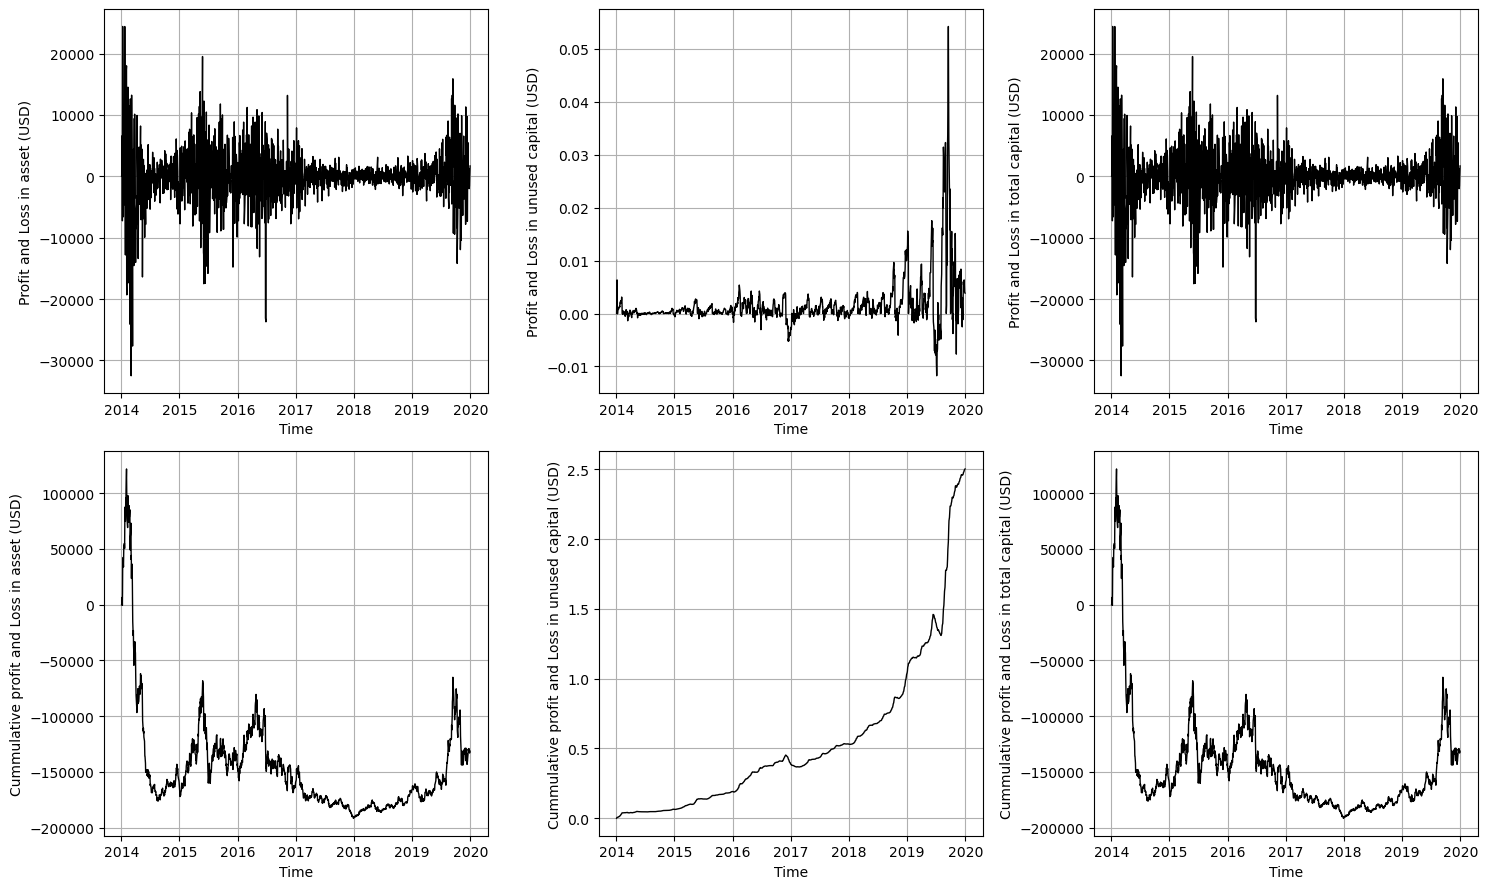

In [22]:
plot_PnL(df['Date'], result['dV'], result['dVcap'], result['dVtot'])


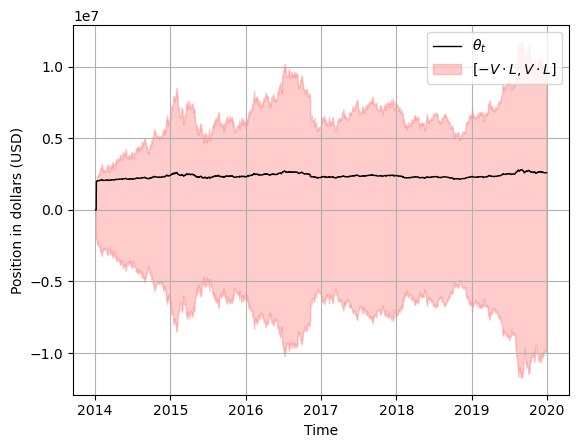

In [52]:
buy_and_hold_signal = np.zeros(len(df))
buy_and_hold_signal[1] = 1

result = compute_position_value(df = df, 
                           signal = buy_and_hold_signal, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)
plot_position(df['Date'], result['theta'], result['Vtot'], leverage=LEVERAGE) 

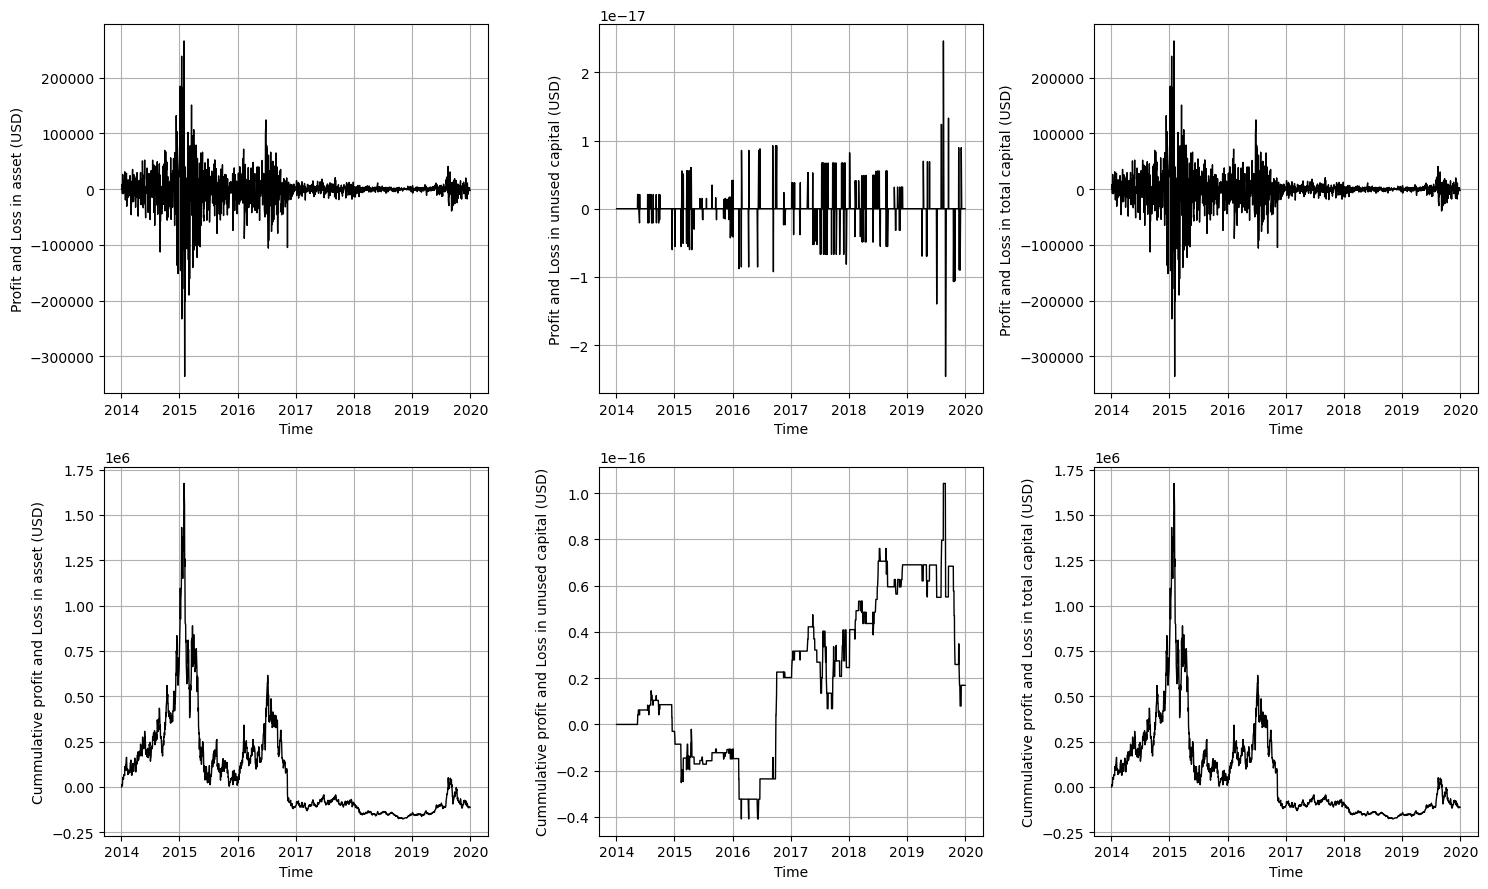

In [20]:
plot_PnL(df['Date'], result['dV'], result['dVcap'], result['dVtot'])